### Loads CSVs, builds DataLoaders, trains ViT-Tiny baseline.

### Saves vit_tiny_baseline.pt and validation metrics.

In [4]:
# Paths & imports
from pathlib import Path
import json, random, numpy as np, pandas as pd
import torch

PROJECT_DIR = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
SPLITS_DIR  = PROJECT_DIR / "splits"
RUNS_DIR    = PROJECT_DIR / "runs"; RUNS_DIR.mkdir(parents=True, exist_ok=True)

with open(SPLITS_DIR / "classes.json", "r", encoding="utf-8") as f:
    classes = json.load(f)["classes"]
class_to_idx = {c:i for i,c in enumerate(classes)}
num_classes = len(classes)

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
device, num_classes, classes[:5]


('cuda', 31, ['Ain', 'Al', 'Alef', 'Beh', 'Dad'])

In [8]:
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from collections import Counter

ImageFile.LOAD_TRUNCATED_IMAGES = False 

class ArSLImageDataset(Dataset):
    def __init__(self, csv_path, class_to_idx, image_size=224, train=True):
        self.df = pd.read_csv(csv_path)
        self.class_to_idx = class_to_idx
        if train:
            self.tx = T.Compose([
                T.Resize((image_size, image_size)),
                T.RandomResizedCrop(image_size, scale=(0.7, 1.0), ratio=(0.9, 1.1)),
                T.RandomHorizontalFlip(0.5),
                T.ColorJitter(0.2, 0.2, 0.2, 0.05),
                T.ToTensor(),
                T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
            ])
        else:
            self.tx = T.Compose([
                T.Resize((image_size, image_size)),
                T.CenterCrop(image_size),
                T.ToTensor(),
                T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
            ])

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["image_path"]
        label = self.class_to_idx[row["label"]]
        try:
            img = Image.open(path).convert("RGB")
        except Exception as e1:
            # Fallback: allow truncated images and retry once
            try:
                ImageFile.LOAD_TRUNCATED_IMAGES = True
                img = Image.open(path)
                img.load()  # force actual load
                img = img.convert("RGB")
            except Exception as e2:
                # Log and skip this sample by moving to the next item
                print(f"[WARN] Bad image skipped: {path} | {e2}")
                # pick a different index to keep the batch size consistent
                new_idx = (idx + 1) % len(self.df)
                row2 = self.df.iloc[new_idx]
                path2 = row2["image_path"]
                label2 = self.class_to_idx[row2["label"]]
                img2 = Image.open(path2).convert("RGB")
                return self.tx(img2), label2

        return self.tx(img), label

# Build loaders
TRAIN_CSV = SPLITS_DIR / "train.csv"
VAL_CSV   = SPLITS_DIR / "val.csv"
TEST_CSV  = SPLITS_DIR / "test.csv"

tr_ds = ArSLImageDataset(TRAIN_CSV, class_to_idx, 224, train=True)
va_ds = ArSLImageDataset(VAL_CSV,   class_to_idx, 224, train=False)
te_ds = ArSLImageDataset(TEST_CSV,  class_to_idx, 224, train=False)

train_labels = pd.read_csv(TRAIN_CSV)["label"].astype(str).tolist()
cnt = Counter(train_labels)
weights = [1.0 / cnt[l] for l in train_labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

BATCH_SIZE = 64
NUM_WORKERS = 4  # if notebook issues → set 0

tr_ld = DataLoader(tr_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
va_ld = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
te_ld = DataLoader(te_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

xb, yb = next(iter(tr_ld))
xb.shape, yb.shape


(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [9]:
import timm, torch.nn as nn, torch.nn.functional as F
from sklearn.metrics import f1_score, precision_recall_fscore_support
import numpy as np, time

model = timm.create_model("vit_tiny_patch16_224", pretrained=True, num_classes=num_classes).to(device)

# Weighted CE for imbalance
class_order = classes  # same order as class_to_idx
class_weights = torch.tensor([1.0 / cnt[c] for c in class_order], dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


/tmp/ipykernel_8772/2170962256.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


In [10]:
def run_epoch(loader, train=True):
    model.train(train)
    total_loss = 0.0
    y_true, y_pred = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(optimizer); scaler.update()
        total_loss += float(loss.item()) * x.size(0)
        y_true.extend(y.detach().cpu().numpy().tolist())
        y_pred.extend(logits.argmax(dim=-1).detach().cpu().numpy().tolist())
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    acc = (np.array(y_true) == np.array(y_pred)).mean()
    return total_loss / len(loader.dataset), acc, macro_f1

best_f1 = -1.0
EPOCHS = 15
for ep in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc, tr_f1 = run_epoch(tr_ld, train=True)
    va_loss, va_acc, va_f1 = run_epoch(va_ld, train=False)
    scheduler.step()
    print(f"Epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.3f}/{tr_f1:.3f} | "
          f"val {va_loss:.4f}/{va_acc:.3f}/{va_f1:.3f} | {(time.time()-t0)/60:.1f} min")
    if va_f1 > best_f1:
        best_f1 = va_f1
        torch.save({"model": model.state_dict(), "classes": classes}, RUNS_DIR / "vit_tiny_baseline.pt")


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 01 | train 1.1296/0.670/0.669 | val 0.3641/0.877/0.876 | 2.2 min


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 02 | train 0.2909/0.904/0.904 | val 0.2967/0.904/0.902 | 2.2 min


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 03 | train 0.2003/0.933/0.933 | val 0.1871/0.939/0.937 | 2.3 min


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 04 | train 0.1427/0.953/0.953 | val 0.2378/0.932/0.931 | 2.3 min


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 05 | train 0.1207/0.964/0.964 | val 0.2280/0.936/0.933 | 2.2 min


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 06 | train 0.0932/0.971/0.972 | val 0.1973/0.942/0.940 | 2.3 min


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 07 | train 0.0810/0.976/0.976 | val 0.2059/0.943/0.942 | 2.2 min


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 08 | train 0.0558/0.985/0.985 | val 0.2019/0.947/0.945 | 2.2 min


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 09 | train 0.0436/0.987/0.987 | val 0.1572/0.958/0.957 | 2.2 min


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 10 | train 0.0232/0.994/0.994 | val 0.1769/0.962/0.960 | 2.2 min


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 11 | train 0.0184/0.995/0.995 | val 0.1538/0.969/0.966 | 2.2 min


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 12 | train 0.0094/0.998/0.998 | val 0.1779/0.968/0.966 | 2.2 min


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 13 | train 0.0068/0.998/0.998 | val 0.1676/0.969/0.968 | 2.2 min


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 14 | train 0.0095/0.998/0.998 | val 0.1705/0.969/0.968 | 2.2 min


/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_8772/552178486.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 15 | train 0.0056/0.999/0.999 | val 0.1679/0.970/0.969 | 2.3 min


In [13]:
# Load best & evaluate on val
ck = torch.load(RUNS_DIR / "vit_tiny_baseline.pt", map_location="cpu")
model.load_state_dict(ck["model"], strict=False)
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x, y in va_ld:
        x = x.to(device); y = y.to(device)
        logits = model(x)
        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(logits.argmax(-1).cpu().numpy().tolist())

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=list(range(num_classes)), average=None)
per_class = pd.DataFrame({"precision": p, "recall": r, "f1": f1}, index=classes).sort_values("f1", ascending=False)
per_class.head(10)


,precision,recall,f1
Alef,1.000000,1.00000,1.000000
Dad,1.000000,1.00000,1.000000
Lam,1.000000,1.00000,1.000000
Kaf,1.000000,1.00000,1.000000
Seen,1.000000,1.00000,1.000000
Waw,1.000000,1.00000,1.000000
Sheen,1.000000,0.97619,0.987952
Yeh,1.000000,0.97561,0.987654
Khah,0.974359,1.00000,0.987013
Meem,0.974359,1.00000,0.987013


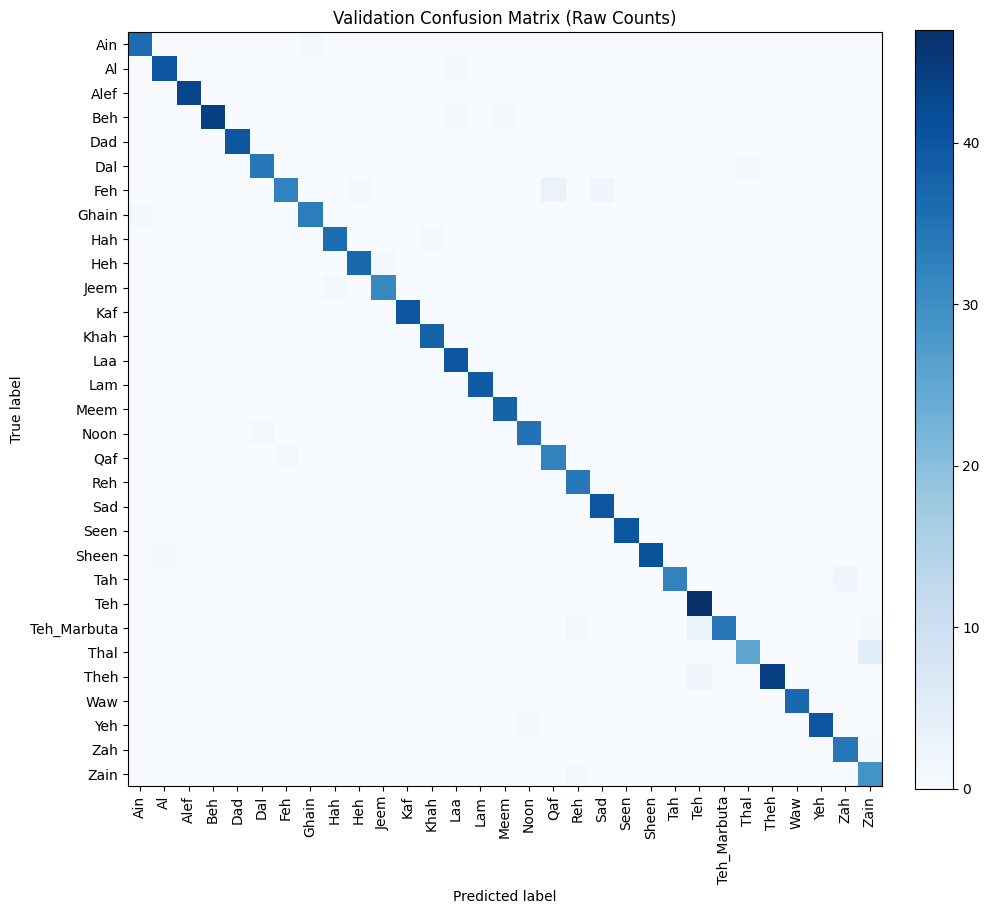

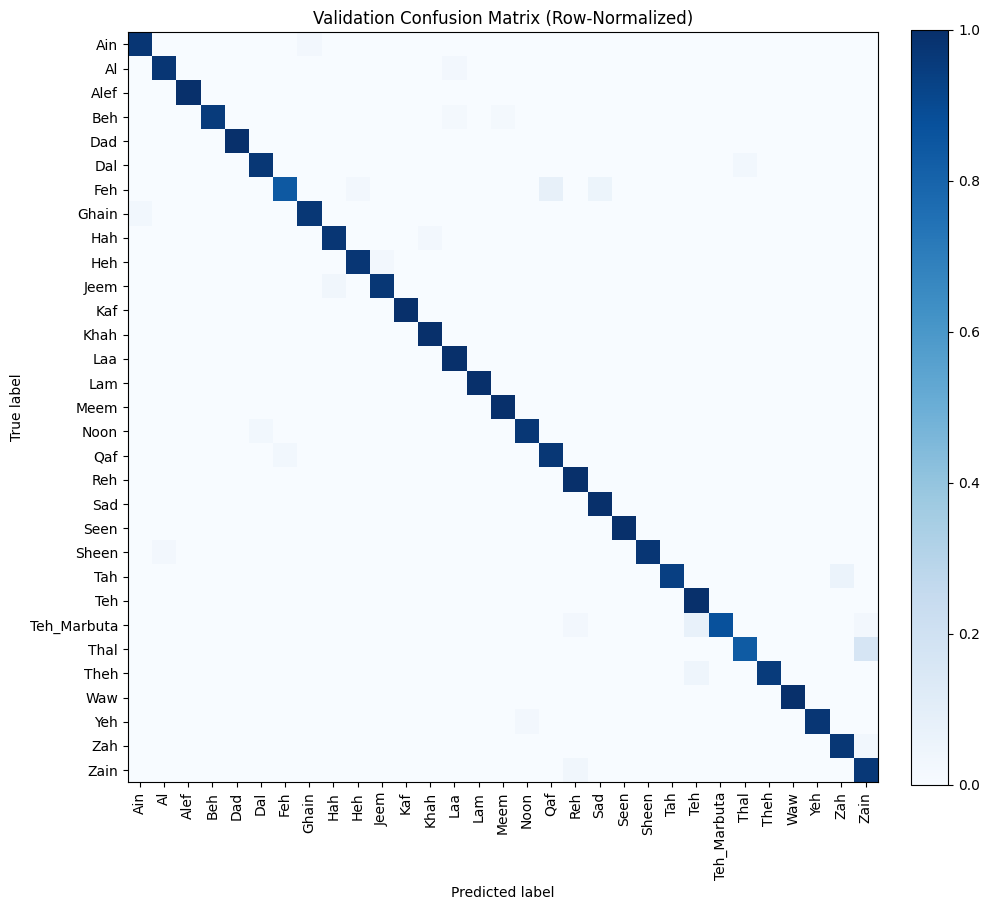

Saved: /home/noushath/NSResearch/ASLR/runs/cm_val_raw.png
Saved: /home/noushath/NSResearch/ASLR/runs/cm_val_norm.png


In [15]:
# Confusion matrix (raw and normalized) — compute, plot, and save
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1) Collect predictions on validation set
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in va_ld:
        x = x.to(device); y = y.to(device)
        logits = model(x)
        y_true.extend(y.cpu().numpy().tolist())
        y_pred.extend(logits.argmax(-1).cpu().numpy().tolist())

y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)

# 2) Compute confusion matrices
cm_raw = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
cm_norm = cm_raw.astype(float) / cm_raw.sum(axis=1, keepdims=True).clip(min=1e-9)  # row-normalized (recall)

# 3) Plot helpers
def plot_cm(cm, class_names, title="Confusion Matrix", normalize=False, save_path=None):
    k = len(class_names)
    # dynamic figure size: ~0.35 inch per class, clamped
    side = max(6, min(18, int(0.35 * k)))
    plt.figure(figsize=(side, side))
    im = plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(k)
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Optional annotations for small class counts
    if k <= 20:
        fmt = ".2f" if normalize else "d"
        thresh = cm.max() / 2. if cm.size > 0 else 0.5
        for i in range(k):
            for j in range(k):
                val = format(cm[i, j], fmt)
                plt.text(j, i, val,
                         ha="center", va="center",
                         color="white" if cm[i, j] > thresh else "black", fontsize=8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

# 4) Plot & save
cm_raw_path  = RUNS_DIR / "cm_val_raw.png"
cm_norm_path = RUNS_DIR / "cm_val_norm.png"

plot_cm(cm_raw,  classes, title="Validation Confusion Matrix (Raw Counts)", normalize=False, save_path=cm_raw_path)
plot_cm(cm_norm, classes, title="Validation Confusion Matrix (Row-Normalized)", normalize=True,  save_path=cm_norm_path)

print(f"Saved: {cm_raw_path}")
print(f"Saved: {cm_norm_path}")


In [16]:
!pip install -q pytorch-grad-cam


error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [18]:
import json, os, numpy as np, torch
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
import timm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

# ---- Paths & device ----
PROJECT_DIR = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
SPLITS_DIR  = PROJECT_DIR / "splits"
RUNS_DIR    = PROJECT_DIR / "runs"
VAL_CSV     = SPLITS_DIR / "val.csv"
CKPT_PATH   = RUNS_DIR / "vit_tiny_baseline.pt"
OUT_DIR     = RUNS_DIR / "attn_rollout_vit_tiny"; OUT_DIR.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---- Load classes & model (must match training arch) ----
with open(SPLITS_DIR / "classes.json", "r", encoding="utf-8") as f:
    classes = json.load(f)["classes"]
num_classes = len(classes)

model = timm.create_model("vit_tiny_patch16_224", pretrained=False, num_classes=num_classes).to(device)
ck = torch.load(CKPT_PATH, map_location="cpu")
model.load_state_dict(ck["model"], strict=False)
model.eval()

# ---- Eval transform (match your validation transform) ----
image_size = 224
val_tf = T.Compose([
    T.Resize((image_size, image_size)),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

def load_pil(path): return Image.open(path).convert("RGB")
def to_model_input(img): return val_tf(img).unsqueeze(0).to(device)  # (1,3,H,W)

# ---- Monkey-patch Attention.forward to capture attention weights ----
from types import MethodType

attn_records = []     # will store per-block attention: [tensor B x H x N x N, ...]
orig_forwards = []    # to restore later
attn_modules = []     # list of attention modules we patched

def make_capturing_forward(attn_mod):
    """Return a forward(x) that computes attention, stores it, then returns normal output."""
    # capture shapes & params from module
    num_heads = attn_mod.num_heads
    qkv = attn_mod.qkv
    proj = attn_mod.proj
    attn_drop = attn_mod.attn_drop
    proj_drop = attn_mod.proj_drop
    scale = attn_mod.scale

    def forward(x):
        B, N, C = x.shape
        qkv_out = qkv(x)  # (B, N, 3*C)
        qkv_out = qkv_out.reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv_out[0], qkv_out[1], qkv_out[2]  # (B, heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * scale   # (B, heads, N, N)
        attn = attn.softmax(dim=-1)
        attn_rec = attn.detach().cpu()
        attn = attn_drop(attn)

        out = attn @ v                              # (B, heads, N, head_dim)
        out = out.transpose(1, 2).reshape(B, N, C)  # (B, N, C)
        out = proj(out)
        out = proj_drop(out)

        # record AFTER softmax, BEFORE v @ ...  (common practice)
        attn_records.append(attn_rec)
        return out

    return forward

# Patch all blocks
for blk in model.blocks:
    attn = blk.attn
    attn_modules.append(attn)
    orig_forwards.append(attn.forward)
    attn.forward = MethodType(make_capturing_forward(attn), attn)

# ---- Helpers: rollout & overlay ----
def attention_rollout(attn_list):
    """
    attn_list: list of tensors [B, heads, N, N] (one per block, order of forward)
    Returns joint attention from CLS to all tokens: [B, N-1]
    """
    # average heads per block
    A = [a.mean(dim=1) for a in attn_list]  # [(B,N,N), ...]
    # Normalize rows (stochastic matrices)
    A = [a / (a.sum(dim=-1, keepdim=True) + 1e-8) for a in A]
    # Add identity & renormalize (residual connection proxy)
    A = [((torch.eye(a.size(-1))[None] + a) / 2.0) for a in A]

    joint = A[0]
    for a in A[1:]:
        joint = torch.bmm(a, joint)  # (B,N,N)
    cam = joint[:, 0, 1:]  # CLS-to-patch
    return cam

def overlay_heatmap(rgb_float01, heat, alpha=0.5, cmap='jet'):
    heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)
    cm = plt.get_cmap(cmap)(heat)[..., :3]   # HxWx3
    overlay = (1 - alpha) * rgb_float01 + alpha * cm
    return (np.clip(overlay, 0, 1) * 255).astype(np.uint8)

# ---- Select a subset of validation images ----
val_df = pd.read_csv(VAL_CSV)
N = min(30, len(val_df))
subset = val_df.sample(N, random_state=42).reset_index(drop=True)

# ---- Run & save overlays ----
for i, row in subset.iterrows():
    img_path, true_label_name = row["image_path"], row["label"]
    try:
        pil = load_pil(img_path)
    except Exception as e:
        print(f"[WARN] skip {img_path}: {e}")
        continue

    x = to_model_input(pil)
    attn_records.clear()  # clear previous captures

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=-1)
        pred_id = int(probs.argmax(dim=-1).item())
        conf = float(probs.max().item())

    if len(attn_records) == 0:
        print(f"[WARN] no attention captured for {img_path}")
        continue

    cam_tokens = attention_rollout(attn_records)  # (1, N-1)

    # For ViT patch16/224 → 14x14 patches
    side = int(np.sqrt(cam_tokens.shape[-1]))
    cam_map = cam_tokens[0].reshape(side, side).numpy()
    cam_map = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min() + 1e-8)


Device: cuda


TypeError: make_capturing_forward.<locals>.forward() got an unexpected keyword argument 'attn_mask'

In [19]:
import torch, numpy as np
from PIL import Image
import torchvision.transforms as T

model.eval()
pil = Image.open(val_df.iloc[0]["image_path"]).convert("RGB")
x = val_tf(pil).unsqueeze(0).to(device).requires_grad_(True)

logits = model(x)
pred = logits.argmax(dim=-1)
logits[0, pred].backward()

grad = x.grad.detach().abs().mean(dim=1)[0].cpu().numpy()  # HxW
grad = (grad - grad.min()) / (grad.max() - grad.min() + 1e-8)
grad_up = np.array(Image.fromarray((grad*255).astype(np.uint8)).resize(pil.size, resample=Image.BILINEAR)) / 255.0

overlay = (0.55 * (np.array(pil)/255.0) + 0.45 * plt.get_cmap('jet')(grad_up)[..., :3])
Image.fromarray((np.clip(overlay,0,1)*255).astype(np.uint8))


TypeError: make_capturing_forward.<locals>.forward() got an unexpected keyword argument 'attn_mask'